#Zakaria ABDALLAH

## Rotation Prediction
In [1], authors propose to predict the geometric transformation applied to the entire image

<center width="100%"><img src="https://miro.medium.com/v2/resize:fit:908/1*enAk96Zn6andqoBetBy5Jg.png" width="800px" style="padding-top: 10px; padding-bottom: 10px"></center>

They propose to use rotations by 0, 90, 180, 270 degrees as trasformations.

[1] S. Gidaris et al. “Unsupervised Representation Learning by Predicting Image Rotations”. In: ICLR. 2018.

Let's load all libraries, we will use pytorch and pytorch vision, and check whether we are using CPU or GPU

In [ ]:
import os

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

## Torchvision
from torchvision import transforms
from torchvision.datasets import STL10
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler

## Plot Options
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.set_cmap("cividis")
%matplotlib inline
sns.set_theme()

# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()
print("Number of workers:", NUM_WORKERS)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# For reproducibility
np.random.seed(666)
torch.manual_seed(666)

try:
  import google.colab
  IN_COLAB = True
  !pip install gdown==4.6.0 # with the following versions, there is an error
except:
  IN_COLAB = False

Hfactory=False # put equal to True, if you are using HFactory
if Hfactory:
    !pip install gdown==4.6.0 # with the following versions, there is an error

import gdown

Number of workers: 2
  Attempting uninstall: gdown
    Found existing installation: gdown 5.2.0
    Uninstalling gdown-5.2.0:
      Successfully uninstalled gdown-5.2.0


<Figure size 640x480 with 0 Axes>

In [ ]:
print("Using torch", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print ("MPS device found.")
elif torch.backends.cuda.is_built():
    device = torch.device("cuda:0") # we use one GPU, the first one
    print ("CUDA device found.")
else:
   device = torch.device("cpu")
   print('No MPS or CUDA has been found. PyTorch will use CPU.')

Using torch 2.5.1+cu124
CUDA device found.


As Dataset, we will use the STL-10 dataset (https://cs.stanford.edu/~acoates/stl10/).
It is an image recognition dataset for developing self-supervised and unsupervised feature learning, deep learning algorithms. It is inspired by the CIFAR-10 dataset but with some modifications. In particular, each class has fewer labeled training examples than in CIFAR-10, but a very large set of unlabeled examples is provided.

Overview of the dataset:
- 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.
- Images are 96x96 pixels, color.
- 5000 training images (10 pre-defined folds), 8000 test images.
- 100000 unlabeled images. These examples are extracted from a similar but broader distribution of images. For instance, it contains other types of animals (bears, rabbits, etc.) and vehicles (trains, buses, etc.) in addition to the ones in the labeled set.
- Images were acquired from labeled examples on $ImageNet$.

Pytorch proposes two practical data primitives, called DataSet and DataLoader, to handle datasets for pre-processing and training.
There are many data-sets pre-loaded, such as STL-10. For more info: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In particular, we can easily compose several data-augmentations (transformations), that are automatically applied to the images of the dataset. Here we have an exemple with the transformations used in [1].

We will use these transformations in the following.

**Question**: What's the size of the images after the transformations ? We have two different transformations, one for Training and one for Testing. Why in your opinion ?

**Answer** :
After applying transformations, the images are resized to 224×224 pixels for both training and testing.

During training, the transformations include RandomResizedCrop and RandomHorizontalFlip:

- These introduce randomness, which enhances the model’s ability to generalize and reduces overfitting.
- The model learns to handle variations by seeing different augmented versions of the same image.

For testing, the transformations involve Resize(256) followed by CenterCrop(224):

- This ensures that all images are uniformly processed, maintaining a consistent input size.
- Unlike training, no randomness is introduced, ensuring reproducibility and reliable evaluation results.


In [ ]:
transformTrain = transforms.Compose([
         transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # these are the average and std from ImageNet
         ])

transformTest = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
         ])

We will use only the training and test datasets (few images) to speed up computations.
- If you are using Google Colab, the STL10 dataset will be downloaded in `./data`. if you have already downloaded it in your Google Drive, you can mount it using the following line of code

from google.colab import drive

drive.mount('/content/drive')

and then either change the path.

- If you are running the code locally, just copy/paste the path of the folder where you have downloaded the dataset. In the code, I assume you have `stl10_binary.tar.gz` and the folder `stl10_binary` inside the `./data`folder.

In [ ]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if IN_COLAB:
    #data_directory="./" # decomment it if you do NOT use Google Drive
    data_directory="/content/drive/MyDrive/TP/"  # decomment it if you USE Google Drive and copy/paste the path to your Google Drive
elif Hfactory:
    data_directory="./"
else:
    data_directory="/Users/pgori/Nextcloud/Lavoro/Corsi/MachineLearning/DataSets-TP/" # copy/paste the path of the folder with STL dataset in your computer


train_dataset = STL10(root=data_directory+"data", split="train", download=True, transform=transformTrain)
test_dataset = STL10(root=data_directory+"data", split="test", download=True, transform=transformTest)

100%|██████████| 2.64G/2.64G [01:28<00:00, 29.8MB/s]


Extracting /content/drive/MyDrive/TP/data/stl10_binary.tar.gz to /content/drive/MyDrive/TP/data
Files already downloaded and verified


Let's have a look at the training and test datasets.

In [ ]:
# Train dataset
classes=train_dataset.classes
print(classes)
print('Number images in Train dataset:' , len(train_dataset)) # retrieve length of dataset
print(train_dataset[3][0].shape) # this is one image
print(train_dataset[3][1]) # this is a label

#Test dataset
print('Number images in Test dataset:' ,len(test_dataset))
print(test_dataset[0][0].shape) # this is one image

['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
Number images in Train dataset: 5000
torch.Size([3, 224, 224])
6
Number images in Test dataset: 8000
torch.Size([3, 224, 224])


Let's plot few images to see how are they. We need to de-normalize images using the statics of ImageNet (images come from ImageNet)

In [ ]:
def imshowSTL10(dataset,rows=3,columns=3,figsize=(8, 8)):
    fig = plt.figure(figsize=figsize)
    for i in range(1, rows*columns+1):
      img = dataset[i][0]

      #REMOVE NORMALIZATION
      mean = torch.tensor([0.485, 0.456, 0.406])
      std = torch.tensor([0.229, 0.224, 0.225])
      unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
      # Clip values to range [0,1] -> possible rounding errors during normalization
      img = np.clip(unnormalize(img).numpy(),0,1)

      label = dataset[i][1]
      fig.add_subplot(rows, columns, i)
      plt.title(dataset.classes[label])
      plt.imshow(np.transpose(img, (1, 2, 0)))
      plt.axis("off")
    plt.show()

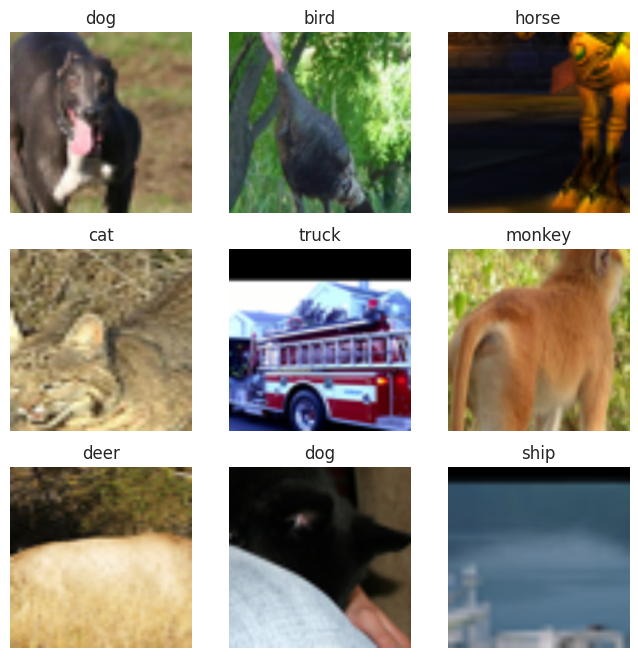

In [ ]:
imshowSTL10(train_dataset)

Now it's time to implement our network.

Since STL10 comes from ImageNet, we take the same network proposed for ImageNet in [1], inspired by AlexNet.

Here you can find the (modified) version of AlexNet (e.g., no DropOut) borrowed from the GitHub of the authors.  

**Question**: Choose an approriate value for num_classes and explain why

**Answer** :

The appropriate choice for num_classes is 4, as the model is designed to classify images based on their rotation angles. Since the possible rotations are 0°, 90°, 180°, and 270°, the model needs to distinguish between these four categories, making 4 the correct number of classes.

In [ ]:
# Code borrowed from https://github.com/gidariss/FeatureLearningRotNet
# AlexNet
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        num_classes = 4

        conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
        )
        pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        conv3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
        )
        conv4 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        conv5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        num_pool5_feats = 6 * 6 * 256
        fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_pool5_feats, 4096, bias=False),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096, bias=False),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
        )
        classifier = nn.Sequential(
            nn.Linear(4096, num_classes),
        )

        self._feature_blocks = nn.ModuleList([
            conv1,
            pool1,
            conv2,
            pool2,
            conv3,
            conv4,
            conv5,
            pool5,
            fc_block,
            classifier,
        ])
        self.all_feat_names = [
            'conv1',
            'pool1',
            'conv2',
            'pool2',
            'conv3',
            'conv4',
            'conv5',
            'pool5',
            'fc_block',
            'classifier',
        ]
        assert(len(self.all_feat_names) == len(self._feature_blocks))

    def _parse_out_keys_arg(self, out_feat_keys):

        # By default return the features of the last layer / module.
        out_feat_keys = [self.all_feat_names[-1],] if out_feat_keys is None else out_feat_keys

        if len(out_feat_keys) == 0:
            raise ValueError('Empty list of output feature keys.')
        for f, key in enumerate(out_feat_keys):
            if key not in self.all_feat_names:
                raise ValueError('Feature with name {0} does not exist. Existing features: {1}.'.format(key, self.all_feat_names))
            elif key in out_feat_keys[:f]:
                raise ValueError('Duplicate output feature key: {0}.'.format(key))

        # Find the highest output feature in `out_feat_keys
        max_out_feat = max([self.all_feat_names.index(key) for key in out_feat_keys])

        return out_feat_keys, max_out_feat

    def forward(self, x, out_feat_keys=None):
        """Forward an image `x` through the network and return the asked output features.
        Args:
          x: input image.
          out_feat_keys: a list/tuple with the feature names of the features
                that the function should return. By default the last feature of
                the network is returned.
        Return:
            out_feats: If multiple output features were asked then `out_feats`
                is a list with the asked output features placed in the same
                order as in `out_feat_keys`. If a single output feature was
                asked then `out_feats` is that output feature (and not a list).
        """
        out_feat_keys, max_out_feat = self._parse_out_keys_arg(out_feat_keys)
        out_feats = [None] * len(out_feat_keys)

        feat = x
        for f in range(max_out_feat+1):
            feat = self._feature_blocks[f](feat)
            key = self.all_feat_names[f]
            if key in out_feat_keys:
                out_feats[out_feat_keys.index(key)] = feat

        out_feats = out_feats[0] if len(out_feats)==1 else out_feats
        return out_feats

    def get_L1filters(self):
        convlayer = self._feature_blocks[0][0]
        batchnorm = self._feature_blocks[0][1]
        filters = convlayer.weight.data
        scalars = (batchnorm.weight.data / torch.sqrt(batchnorm.running_var + 1e-05))
        filters = (filters * scalars.view(-1, 1, 1, 1).expand_as(filters)).cpu().clone()

        return filters

And here it's the most important part of the code.

We build the RotationPrediction Module.

As in [1], we use the 'conv5' layer as representation features and a small classifier, as proposed in the paper.

The key part is in the 'forward' function and in '_preprocess'.

**Question**: complete the code XXXXXX in the '_preprocess' function. Remember that we are implementing the method of [1] as shown in the figure at the beginning of this TP.

In [ ]:
## Joint optimization
class RotationPrediction(nn.Module):
    metrics = ['Loss', 'Acc1']
    metrics_fmt = [':.4e', ':6.2f']

    def __init__(self, n_classes_classifier, device):
        super().__init__()
        self.device=device
        self.model = AlexNet().to(self.device)
        self.latent_dim = 256 * 6 * 6 # as defined in [1]
        self.feat_layer = 'conv5' # as defined in [1]
        self.n_classes_classifier = n_classes_classifier

    # Same Classifier as defined in [1]
    def construct_classifier(self):
        classifier = nn.Sequential(
            nn.AdaptiveMaxPool2d((6, 6)),
            nn.BatchNorm2d(256, affine=False),
            nn.Flatten(),
            nn.Linear(self.latent_dim, self.n_classes_classifier)
        )
        classifier=classifier.to(self.device)
        return classifier

    def forward(self, images):
        images=images.to(self.device)
        batch_size = images.shape[0]

        #images must have a torch.Size([batch_size, Channels, Height, Width])
        #target must have a torch.Size([batch_size])
        images, targets = self._preprocess(images)
        targets = targets.to(self.device)

        logits, zs = self.model(images, out_feat_keys=('classifier', self.feat_layer))
        loss = F.cross_entropy(logits, targets).to(self.device)

        pred = logits.argmax(dim=-1)
        correct = pred.eq(targets).float().sum()
        acc = correct / targets.shape[0] * 100.

        zs = zs[:batch_size]
        return dict(Loss=loss, Acc1=acc), zs[:batch_size]

    def encode(self, images, flatten=True):
        zs = self.model(images, out_feat_keys=(self.feat_layer,))
        return zs.flatten(start_dim=1)

    def _preprocess(self, images):
        batch_size = images.shape[0]

        # Original images
        X0 = images

        # 90° rotation: permute and flip
        X1 = images.permute(0, 1, 3, 2).flip(dims=[2])

        # 180° rotation: two flips
        X2 = images.flip(dims=[2, 3])

        # 270° rotation: transposing and flipping
        X3 = images.permute(0, 1, 3, 2).flip(dims=[3])

        images_batch = torch.cat([X0, X1, X2, X3], dim=0)

        targets = torch.arange(4, dtype=torch.long).repeat_interleave(batch_size)

        return images_batch, targets

Here we train our algorithm and evaluate its prediction power on a test set (function 'validate') using the function `accuracy`.

**Question**: Do you understand what the function accuracy compute ? Explain what the output `res` contains

**Answer** :

The accuracy function evaluates how well the model's predictions match the actual labels by computing top-k accuracy over a batch of samples.

- Top-k accuracy checks whether the correct label appears within the top-k highest probability predictions for each sample.
- This allows us to assess the model's performance not just on its most confident prediction (top-1 accuracy) but also on broader rankings (top-5 accuracy, etc.).


The output res is a list where each element corresponds to a specific k value in the topk parameter. Each entry in res is a tensor containing the computed accuracy (expressed as a percentage) for that particular k.

For example, if topk=(1, 5), then:

- res[0] represents top-1 accuracy (percentage of times the top prediction is correct).
- res[1] represents top-5 accuracy (percentage of times the correct label appears within the top 5 predictions).

In [ ]:
def accuracy(output, target, topk=(1,)):

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True) # sliced torch.argsort (for each row, it outputs the indices containing the k max values)
        pred = pred.t() # transpose to get batches as last dimension
        correct = pred.eq(target.view(1, -1).expand_as(pred)) # first transpose then expand target to be the same size as pred and then elementwise-equality

        # compute number of samples in the batch that has correct label in the k highest predictions
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

Now we can define our train function.


**Question**: Look at the optimization process and describe it. How do we minimize the rotation prediction module and classifier ? Could you do it differently ?

**Answer** :

The training process optimizes two components separately:

1-Rotation Prediction Module

- Loss: Self-supervised rotation loss (out['Loss']).
- Optimizer: optimizer.

2-Classifier

- Loss: Cross-entropy between logits and target labels.
- Optimizer: optimizer_classifier.

Each component is updated independently in alternating steps.

Alternative Approach: Joint Optimization

Instead of separate updates, we could define a combined loss:

$\mathcal{L}_{\text{total}} = \lambda_1 \mathcal{L}_{\text{rotation}} + \lambda_2 \mathcal{L}_{\text{classification}}
$

where λ₁ and λ₂ balance the contributions of both tasks. This enables end-to-end training, potentially leading to better feature learning.


In [ ]:
def train(train_loader, model, classifier, optimizer, optimizer_classifier, epoch, device):

    model.train()
    classifier.train()
    top1=[]
    top5=[]

    for i, (images, target) in enumerate(train_loader):
        # compute loss
        bs = images.shape[0]
        images = images.to(device)
        target = target.to(device)
        out, zs = model(images)
        zs = zs.detach() # detach from the graph,  requires_grad = False

        # compute optimizer step for ssl task using the previously defined Loss function of the model
        optimizer.zero_grad()
        out['Loss'].backward()
        optimizer.step()

        # compute loss
        logits = classifier(zs)
        loss = F.cross_entropy(logits, target)

        # compute accuracy
        acc1, acc5 = accuracy(logits, target, topk=(1, 5))
        top1.append(acc1[0])
        top5.append(acc5[0])

        # computeoptimizer step for classifier using the cross entropy loss
        optimizer_classifier.zero_grad()
        loss.backward()
        optimizer_classifier.step()

        #if i % 20 == 0:
        #    print('Epoch {}, Iter: {} out of {}, Average loss: {:.4f}, acc 1: {:.4f}'.format(epoch, i, len(train_loader), loss / len(train_loader.dataset),acc1[0]))

    print('Epoch: {}, Average loss: {:.4f}, Average acc 1: {:.4f}, Average acc 5: {:.4f}'.format(epoch, loss / len(train_loader.dataset),sum(top1)/len(top1), sum(top5)/len(top5)))
    return sum(top1)/len(top1), sum(top5)/len(top5)

Here, we define the:
- DataLoader, a pytorch object that wraps an iterable around the Dataset to enable easy access to the samples duing training or validation
- optimization process
- the sceduler
- all hyper-parameters (max epochs, batch size, lr, weight decay,etc.)

Please note that it will lauch the training process. It can last some time... OR

you can directly load a pre-trained model in the following cell !

**Question**: what's the correct value for n_classes_classifier using the STL dataset ?

**Answer** :
The STL-10 dataset consists of 10 classes, including airplane, bird, car, cat, deer, dog, horse, monkey, ship, and truck. Hence, the appropriate value for n_classes_classifier is 10 to match the number of categories in the dataset.

In [ ]:
maxepochs=15 # maximum number of epochs
bs=256 # batch size
lr_initial=0.01 # initial learning rate
wd=5e-4 # weight decay
n_classes_classifier = 10

# Ensure that you are using GPU
print("Device:", device)

train_loader = data.DataLoader(train_dataset, batch_size=bs, num_workers=NUM_WORKERS, shuffle=True, pin_memory=False)

model = RotationPrediction(n_classes_classifier=n_classes_classifier, device=device)
classifier = model.construct_classifier()

optimizer = torch.optim.Adam(model.parameters(), lr=lr_initial, weight_decay=wd)
optimizer_classifier = torch.optim.Adam(classifier.parameters(), lr=lr_initial)

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=maxepochs)
scheduler_classifier = lr_scheduler.CosineAnnealingLR(optimizer_classifier, T_max=maxepochs)

top1Train=[]
top5Train=[]

for epoch in range(maxepochs):
  top1Tr, top5Tr = train(train_loader, model, classifier, optimizer, optimizer_classifier, epoch, device)
  top1Train.append(top1Tr)
  top5Train.append(top5Tr)
  scheduler.step()
  scheduler_classifier.step()


Device: cuda:0
Epoch: 0, Average loss: 0.0022, Average acc 1: 16.0237, Average acc 5: 59.2946
Epoch: 1, Average loss: 0.0011, Average acc 1: 17.1232, Average acc 5: 66.9750
Epoch: 2, Average loss: 0.0015, Average acc 1: 18.5903, Average acc 5: 66.2845
Epoch: 3, Average loss: 0.0016, Average acc 1: 19.0510, Average acc 5: 66.8233
Epoch: 4, Average loss: 0.0012, Average acc 1: 19.3716, Average acc 5: 67.4644
Epoch: 5, Average loss: 0.0011, Average acc 1: 19.8909, Average acc 5: 69.3796
Epoch: 6, Average loss: 0.0009, Average acc 1: 20.7560, Average acc 5: 69.8058
Epoch: 7, Average loss: 0.0010, Average acc 1: 21.4373, Average acc 5: 71.3247
Epoch: 8, Average loss: 0.0008, Average acc 1: 22.8631, Average acc 5: 73.9671
Epoch: 9, Average loss: 0.0008, Average acc 1: 23.6650, Average acc 5: 75.0689
Epoch: 10, Average loss: 0.0007, Average acc 1: 25.5480, Average acc 5: 77.4069
Epoch: 11, Average loss: 0.0007, Average acc 1: 26.5085, Average acc 5: 79.1969
Epoch: 12, Average loss: 0.0006, Av

If you want to save your model, we can use torch.save

In [ ]:
os.makedirs(data_directory+'models/', exist_ok=True)
filename = 'models/checkpoint_rotation_2epochs.pth.tar'
torch.save({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'state_dict_classifier': classifier.state_dict(),
                'optimizer_classifier': optimizer_classifier.state_dict(),
                'schedular_classifier': scheduler_classifier.state_dict()
            }, data_directory+filename)

If you want, here you can download the same model as before but already pre-trained for 50 epochs.

It's important to set the 'model.eval()' since we want to evaluate it and not train it (no gradient is computed and parameters are not updated)


In [ ]:
model_path = 'models/checkpoint_rotation_50epochs.pth.tar'

if os.path.isfile(data_directory+model_path):
    print("pre-trained model already downloaded")
else:
    print("downloading the pre-trained model")
    os.makedirs(data_directory+'models/', exist_ok=True)
    file_url = 'https://drive.google.com/uc?id=1ADslBKLjo1ulEfmz12ufEk2cjqnYJVRp'
    gdown.download(file_url, data_directory+model_path)

# Number of classes
n_classes_classifier = 10

# Load checkpoint file of already trained model
ckpt = torch.load(data_directory+model_path,map_location=torch.device(device))

# Load Model parameters and set it into eval mode
model_download = RotationPrediction(n_classes_classifier=n_classes_classifier, device=device)
model_download.load_state_dict(ckpt['state_dict'])
model_download.to(device)
model_download.eval()

# Load classifier model
classifier_download = model_download.construct_classifier()
classifier_download.load_state_dict(ckpt['state_dict_classifier'])
classifier_download.to(device)
classifier_download.eval()


downloading the pre-trained model


Downloading...
From: https://drive.google.com/uc?id=1ADslBKLjo1ulEfmz12ufEk2cjqnYJVRp
To: /content/drive/MyDrive/TP/models/checkpoint_rotation_50epochs.pth.tar
100%|██████████| 686M/686M [00:07<00:00, 91.1MB/s]
<ipython-input-21-52256fce4238>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have

Sequential(
  (0): AdaptiveMaxPool2d(output_size=(6, 6))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=9216, out_features=10, bias=True)
)

Now we can test our model on the test set.

**Question**: complete the code to compute average loss and average acc 1 and average acc 5 on the test set

In [ ]:
def test(test_loader, model, classifier, device):
    # Switch to evaluation mode
    model.eval()
    classifier.eval()

    total_loss = 0
    total_samples = 0
    top1_acc = []
    top5_acc = []

    with torch.no_grad():
        for images, target in test_loader:
            images, target = images.to(device), target.to(device)

            model_output, feature_vectors = model(images)

            rotation_loss = model_output['Loss']
            total_loss += rotation_loss.item()

            predictions = classifier(feature_vectors)
            classification_loss = F.cross_entropy(predictions, target)

            acc1, acc5 = accuracy(predictions, target, topk=(1, 5))
            top1_acc.append(acc1[0])
            top5_acc.append(acc5[0])

            total_samples += images.size(0)

    avg_loss = total_loss / total_samples
    avg_acc1 = torch.stack(top1_acc).mean()
    avg_acc5 = torch.stack(top5_acc).mean()

    return avg_loss, avg_acc1, avg_acc5


In [ ]:
bs=128

# when testing is better to use drop_laste=False to use the entire test set. Otherwise, pytorch divides the dataset into batches and ignores the last batch if it does not reach the requested batch_size (thus when the number of samples is not divisible by the batch size)
test_loader = data.DataLoader(test_dataset, batch_size=bs, num_workers=NUM_WORKERS, shuffle=False, drop_last=False, pin_memory=False)

model_test=model
#model_test=model_download

classifier_test=classifier
#classifier_test=classifier_download

AvgLoss, top1Te, top5Te = test(test_loader, model_test, classifier_test, device)

In [ ]:
print("Test Results:")
print(f" - Average Loss: {AvgLoss:.4f}")
print(f" - Top-1 Accuracy: {top1Te:.2f}%")
print(f" - Top-5 Accuracy: {top5Te:.2f}%")

Test Results:
 - Average Loss: 0.0078
 - Top-1 Accuracy: 36.12%
 - Top-5 Accuracy: 86.21%


In [ ]:
model_test = model_download
classifier_test = classifier_download

In [ ]:
AvgLoss, top1Te, top5Te = test(test_loader, model_test, classifier_test, device)

In [ ]:
print("Test Results:")
print(f" - Average Loss: {AvgLoss:.4f}")
print(f" - Top-1 Accuracy: {top1Te:.2f}%")
print(f" - Top-5 Accuracy: {top5Te:.2f}%")

Test Results:
 - Average Loss: 0.0056
 - Top-1 Accuracy: 47.67%
 - Top-5 Accuracy: 93.13%


**Question**: are you satisfied with the obtained result ? If you had more time, what would you do to improve the results ?

**Answer** :

The results are not very satisfactory. A Top-1 Accuracy of 47.67% is quite low, especially given the complexity of the STL-10 dataset. With more time, improvements could be made by fine-tuning hyperparameters such as the learning rate and weight decay, as well as enhancing data augmentation techniques to help the model generalize better.

However, the Top-5 Accuracy of 93.13% is more encouraging, indicating that the correct class is often among the model’s top five predictions.

**Question**: If you look carefully at the RotationPrediction module, you can see that we optimize the rotation prediction module and the small classifier using *different* optimizers but within the same training. You could also train them separately: first train the rotation prediction module, fix it, and then train the small classifier. Try it and comment the results.

In [ ]:
def train_ssl_module(dataloader, network, optimizer, device):
    """Train the self-supervised learning (SSL) module for rotation prediction."""

    network.train()
    total_training_loss = 0

    for batch, (inputs, _) in enumerate(dataloader):
        inputs = inputs.to(device)

        optimizer.zero_grad()
        output_dict, _ = network(inputs)

        loss_value = output_dict['Loss']
        loss_value.backward()
        optimizer.step()

        total_training_loss += loss_value.item()

    avg_train_loss = total_training_loss / len(dataloader)
    print(f"SSL Training - Avg Loss: {avg_train_loss:.4f}")
    return avg_train_loss


In [ ]:
def fine_tune_classifier(dataloader, feature_extractor, classifier_head, optimizer, device, epochs=5):
    """Train the classifier on top of the frozen feature extractor."""

    feature_extractor.eval()
    classifier_head.train()

    for param in feature_extractor.parameters():
        param.requires_grad = False

    for epoch in range(epochs):
        cumulative_loss = 0
        accuracy_top1 = []
        accuracy_top5 = []

        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            feature_vectors = feature_extractor.encode(images, flatten=False)
            batch_size, num_features = feature_vectors.shape

            spatial_size = int((num_features / 256) ** 0.5)

            if spatial_size * spatial_size * 256 == num_features:
                feature_vectors = feature_vectors.view(batch_size, 256, spatial_size, spatial_size)
            else:
                feature_vectors = feature_vectors.view(batch_size, -1)

            predictions = classifier_head(feature_vectors)
            loss = F.cross_entropy(predictions, labels)

            acc1, acc5 = accuracy(predictions, labels, topk=(1, 5))
            accuracy_top1.append(acc1[0])
            accuracy_top5.append(acc5[0])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            cumulative_loss += loss.item()

        avg_loss = cumulative_loss / len(dataloader)
        avg_acc1 = sum(accuracy_top1) / len(accuracy_top1)
        avg_acc5 = sum(accuracy_top5) / len(accuracy_top5)

        print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}, Top-1 Acc: {avg_acc1:.2f}%, Top-5 Acc: {avg_acc5:.2f}%")

    return avg_loss, avg_acc1, avg_acc5


In [ ]:
def evaluate_ssl_module(dataloader, network, device):
    """Evaluate the self-supervised rotation prediction model."""

    network.eval()
    total_loss = 0
    accuracy_scores = []

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)

            output_dict, _ = network(images)

            loss_value = output_dict['Loss']
            total_loss += loss_value.item()

            accuracy_scores.append(output_dict['Acc1'])

    avg_loss = total_loss / len(dataloader.dataset)
    avg_acc1 = sum(accuracy_scores) / len(accuracy_scores)

    print(f"SSL Evaluation - Avg Loss: {avg_loss:.4f}, Top-1 Accuracy: {avg_acc1:.2f}%")
    return avg_loss, avg_acc1


In [ ]:
def evaluate_classifier(dataloader, feature_extractor, classifier_head, device):
    """Evaluate the classifier performance."""

    feature_extractor.eval()
    classifier_head.eval()

    total_loss = 0
    top1_accuracy = []
    top5_accuracy = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            feature_vectors = feature_extractor.encode(images, flatten=False)
            batch_size, num_features = feature_vectors.shape


            spatial_size = int((num_features / 256) ** 0.5)

            if spatial_size * spatial_size * 256 == num_features:
                feature_vectors = feature_vectors.view(batch_size, 256, spatial_size, spatial_size)
            else:
                feature_vectors = feature_vectors.view(batch_size, -1)

            predictions = classifier_head(feature_vectors)

            loss = F.cross_entropy(predictions, labels)
            acc1, acc5 = accuracy(predictions, labels, topk=(1, 5))

            total_loss += loss.item()
            top1_accuracy.append(acc1[0])
            top5_accuracy.append(acc5[0])

    avg_loss = total_loss / len(dataloader.dataset)
    avg_acc1 = sum(top1_accuracy) / len(top1_accuracy)
    avg_acc5 = sum(top5_accuracy) / len(top5_accuracy)

    print(f"Classifier Evaluation - Loss: {avg_loss:.4f}, Top-1 Acc: {avg_acc1:.2f}%, Top-5 Acc: {avg_acc5:.2f}%")
    return avg_loss, avg_acc1, avg_acc5


In [ ]:
# Hyperparameters
batch_size = 256
learning_rate = 0.01
weight_decay = 5e-4
num_classes = 10
ssl_epochs = 10
classifier_epochs = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", device)


Using Device: cuda


In [ ]:
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, num_workers=NUM_WORKERS, shuffle=True, pin_memory=False)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, num_workers=NUM_WORKERS, shuffle=False, pin_memory=False)

ssl_model = RotationPrediction(n_classes_classifier=num_classes, device=device)


In [ ]:
# Step 1: Train the self-supervised learning (SSL) module
ssl_optimizer = torch.optim.Adam(ssl_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

for epoch in range(ssl_epochs):
    print(f"\nEpoch {epoch+1} - Training Self-Supervised Model:")
    train_ssl_module(train_loader, ssl_model, ssl_optimizer, device)



Epoch 1 - Training Self-Supervised Model:
SSL Training - Avg Loss: 4.8502

Epoch 2 - Training Self-Supervised Model:
SSL Training - Avg Loss: 1.6075

Epoch 3 - Training Self-Supervised Model:
SSL Training - Avg Loss: 1.5404

Epoch 4 - Training Self-Supervised Model:
SSL Training - Avg Loss: 1.6021

Epoch 5 - Training Self-Supervised Model:
SSL Training - Avg Loss: 1.6124

Epoch 6 - Training Self-Supervised Model:
SSL Training - Avg Loss: 1.5278

Epoch 7 - Training Self-Supervised Model:
SSL Training - Avg Loss: 1.4617

Epoch 8 - Training Self-Supervised Model:
SSL Training - Avg Loss: 1.4501

Epoch 9 - Training Self-Supervised Model:
SSL Training - Avg Loss: 1.5046

Epoch 10 - Training Self-Supervised Model:
SSL Training - Avg Loss: 1.3239


In [ ]:
# Step 2: Freeze the SSL model
for param in ssl_model.parameters():
    param.requires_grad = False


In [ ]:
# Step 3: Train the classifier with frozen SSL model
classifier_head = ssl_model.construct_classifier()
classifier_optimizer = torch.optim.Adam(classifier_head.parameters(), lr=learning_rate)

for epoch in range(classifier_epochs):
    print(f"\nEpoch {epoch+1} - Training Classifier:")
    fine_tune_classifier(train_loader, ssl_model, classifier_head, classifier_optimizer, device)



Epoch 1 - Training Classifier:
Epoch 1/5 - Loss: 14.5089, Top-1 Acc: 22.89%, Top-5 Acc: 72.48%
Epoch 2/5 - Loss: 6.4059, Top-1 Acc: 29.64%, Top-5 Acc: 81.15%
Epoch 3/5 - Loss: 4.5781, Top-1 Acc: 34.20%, Top-5 Acc: 85.08%
Epoch 4/5 - Loss: 4.1565, Top-1 Acc: 35.52%, Top-5 Acc: 85.20%
Epoch 5/5 - Loss: 4.2759, Top-1 Acc: 35.92%, Top-5 Acc: 84.69%

Epoch 2 - Training Classifier:
Epoch 1/5 - Loss: 3.7928, Top-1 Acc: 37.17%, Top-5 Acc: 85.56%
Epoch 2/5 - Loss: 4.3890, Top-1 Acc: 35.27%, Top-5 Acc: 82.80%
Epoch 3/5 - Loss: 4.5098, Top-1 Acc: 35.79%, Top-5 Acc: 84.48%
Epoch 4/5 - Loss: 3.8919, Top-1 Acc: 38.02%, Top-5 Acc: 86.32%
Epoch 5/5 - Loss: 3.9392, Top-1 Acc: 38.41%, Top-5 Acc: 86.05%

Epoch 3 - Training Classifier:
Epoch 1/5 - Loss: 3.9826, Top-1 Acc: 39.47%, Top-5 Acc: 85.51%
Epoch 2/5 - Loss: 4.3014, Top-1 Acc: 38.36%, Top-5 Acc: 86.17%
Epoch 3/5 - Loss: 4.1966, Top-1 Acc: 39.58%, Top-5 Acc: 86.08%
Epoch 4/5 - Loss: 4.1160, Top-1 Acc: 40.82%, Top-5 Acc: 86.27%
Epoch 5/5 - Loss: 4.7

In [ ]:
# Step 4: Evaluate self-supervised learning module
print("\nEvaluating SSL Model:")
evaluate_ssl_module(test_loader, ssl_model, device)



Evaluating SSL Model:
SSL Evaluation - Avg Loss: 0.0055, Top-1 Accuracy: 25.00%


(0.005545424014329911, tensor(25., device='cuda:0'))

In [ ]:
print("\nEvaluating Classifier:")
evaluate_classifier(test_loader, ssl_model, classifier_head, device)



Evaluating Classifier:
Classifier Evaluation - Loss: 0.0186, Top-1 Acc: 42.99%, Top-5 Acc: 88.62%


(0.018608674615621566,
 tensor(42.9932, device='cuda:0'),
 tensor(88.6230, device='cuda:0'))

**Self-Supervised Learning (SSL) Model Performance** :

- Average Loss: 0.0055
- Top-1 Accuracy: 25.00%


The SSL model struggles with rotation prediction, as indicated by the low Top-1 accuracy, suggesting that it does not consistently classify rotations correctly.

**Classifier Performance:**

- Loss: 0.0186
- Top-1 Accuracy: 42.99%
- Top-5 Accuracy: 88.62%


The classifier achieves moderate Top-1 accuracy (42.99%), meaning it correctly predicts the class less than half of the time. However, the Top-5 accuracy (88.62%) is much stronger, indicating that the correct label is often among the top predictions.

**Overall Analysis:**

The SSL model's weaker performance suggests that its learned representations may not be optimal, potentially impacting the classifier’s accuracy. Further fine-tuning, better data augmentation, or joint optimization could help improve both modules for better classification results.